# Expense Analyzer

- Date : 01/02/2020
- Author : Aditya Warnulkar (adwarnulkar@gmail.com)

In [4]:
# expense from finance app
expenses_file = '/Users/adwarnulkar/workspace/finance_modeling/notebooks/expenses_november_2020.xls' # Expense report from Toshl finance

# budget allocation for this month
budget_file = '/Users/adwarnulkar/workspace/finance_modeling/notebooks/budget_november_2020.csv' # Budget file as per your standard of living

# 401k , HSA , ESPP contribution
company_deductions = 1376.23 + 1376.23

# Gross - TAX - company deductions
salary = (5553-1737) + (5428-1697.17) - company_deductions # Take home salary (After TAX/ESPP/HSA/401K)

In [5]:
salary

4794.37

In [6]:
company_deductions

2752.46

In [7]:
import sys
import os
import re

import pandas as pd
import numpy as np

import itertools

import matplotlib.pyplot as plt
%matplotlib inline

from bokeh.io import output_notebook , show
output_notebook()

from src import finance_post_process as fin

Loading BokehJS ...

In [8]:
df_expense = pd.read_excel(expenses_file,skiprows=1)
df_expense.head()

,Date,Account,Category,Tags,Amount,Currency,In main currency,Main currency,Description
0,11/1/20,Cash,Fuel,NaN,2.18,USD,2.18,USD,Mobil Mira Mesa
1,11/1/20,Cash,Food & Drinks,NaN,17.88,USD,17.88,USD,Nut Meg Cafe
2,11/1/20,Cash,Food & Drinks,NaN,12.87,USD,12.87,USD,Veggie Grill
3,11/3/20,Cash,Food & Drinks,NaN,6.27,USD,6.27,USD,Bobboi Gelato
4,11/3/20,Cash,Gifts,NaN,25.29,USD,25.29,USD,Hat to Sush


In [9]:
df_budget = pd.read_csv(budget_file)
df_budget.set_index('Category',inplace=True)

In [10]:
df_expense = df_expense.groupby('Category').sum()['Amount']

In [11]:
df_expense = pd.concat([df_budget,df_expense],axis=1,sort=False)
df_expense.fillna(0,inplace=True)
df_expense['leverage'] = df_expense['budget'] - df_expense['Amount']
df_expense['leverage_perc'] = 100 * df_expense['leverage'] / df_expense['budget']
df_expense = df_expense.replace([np.inf, -np.inf], np.nan)
df_expense.fillna(0,inplace=True)
df_expense

,budget,Amount,leverage,leverage_perc
Home & Utilities,1565,1490.00,75.00,4.792332
Office Lunch,200,23.16,176.84,88.420000
Grocery,250,220.34,29.66,11.864000
Food & Drinks,230,279.47,-49.47,-21.508696
Bills,150,88.55,61.45,40.966667
Car,143,109.25,33.75,23.601399
Shopping,100,226.50,-126.50,-126.500000
Fuel,130,102.69,27.31,21.007692
Gifts,50,62.59,-12.59,-25.180000


In [12]:
print(f"Monthly Expenditure : ${df_expense.Amount.sum():.2f}")

Monthly Expenditure : $2602.55


In [13]:
print(f"Total Leverage : ${df_expense.leverage.sum():.2f}")

Total Leverage : $215.45


## Plotting
- https://docs.bokeh.org/en/latest/docs/user_guide/categorical.html

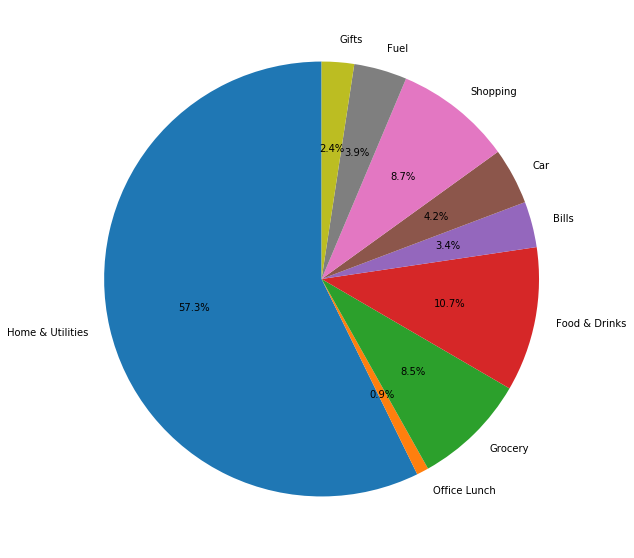

In [14]:
plt.figure(figsize=[10,10])
_ = plt.pie(df_expense.Amount,labels=df_expense.index,shadow=False, startangle=90,autopct='%1.1f%%')

In [15]:
show(fin.plot_expense(df_expense))

# Amount available for investment

In [16]:
salary_take_home = salary
salary_take_home

4794.37

In [17]:
print(f"Total Leverage : ${df_expense.leverage.sum():.2f}")

Total Leverage : $215.45


In [18]:
storage = salary_take_home - df_expense.Amount.sum()
guilt_free_money = 0.1*storage
storage = storage - guilt_free_money
invest_perc = 100*storage/salary_take_home

print(f"Amount available for guilt free expenditure : ${guilt_free_money:.2f}")
print(f"Amount available for investment : ${storage:.2f} {invest_perc:.2f}%")

Amount available for guilt free expenditure : $219.18
Amount available for investment : $1972.64 41.14%


In [19]:
df_goal = pd.read_csv("model_goal_allocation.csv",index_col='goal',usecols=['goal','model_investment'])
df_goal['asset_ratio'] = df_goal.model_investment / df_goal.model_investment.sum()
df_goal['actual_investment'] = df_goal.asset_ratio * storage
df_goal['delta'] = df_goal.actual_investment - df_goal.model_investment
df_goal

,model_investment,asset_ratio,actual_investment,delta
goal,,,,
home,1550.693801,0.507803,1001.711165,-548.982636
vacation,234.204323,0.076694,151.290400,-82.913923
wedding,377.733955,0.123696,244.007115,-133.726840
retirement,891.100000,0.291807,575.629321,-315.470679


In [20]:
df_report = pd.concat([df_expense.Amount,df_goal.actual_investment])

In [21]:
df_report = df_report.append(pd.Series([guilt_free_money],index=['Guilt Free']))

In [22]:
df_report = df_report.to_frame(name='value')
df_report['percentage'] = 100*df_report.value/df_report.value.sum()
df_report["model_value"] = pd.concat([df_expense.budget , df_goal.model_investment])
df_report.fillna(0,inplace=True)
df_report

,value,percentage,model_value
Home & Utilities,1490.000000,31.078119,1565.000000
Office Lunch,23.160000,0.483067,200.000000
Grocery,220.340000,4.595807,250.000000
Food & Drinks,279.470000,5.829129,230.000000
Bills,88.550000,1.846958,150.000000
Car,109.250000,2.278714,143.000000
Shopping,226.500000,4.724291,100.000000
Fuel,102.690000,2.141887,130.000000
Gifts,62.590000,1.305490,50.000000
home,1001.711165,20.893489,1550.693801


In [24]:
df_report.sum()

value          4794.370000
percentage      100.000000
model_value    5871.732079
dtype: float64

In [25]:
df_report.to_csv('report_november_2020.csv')